# Wind & Solar Energy Production Analysis & Forecasting

In [1]:
# =============================
# Step 0: Import Libraries
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


import warnings

warnings.filterwarnings('ignore')

# =============================
# Step 1: Set plotting style
# =============================
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16,8)   # Make plots wider for better visibility
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# =============================
# Step 2: Display all columns and full width
# =============================
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Don't wrap columns
pd.set_option('display.max_rows', 500)       # Adjust rows if needed
pd.set_option('display.float_format', '{:.2f}'.format)  # Format float numbers

print("Libraries imported and display options set successfully!")


Libraries imported and display options set successfully!


# Step 1: Load Dataset

In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/wind-and-solar-energy-production-dataset/Energy Production Dataset.csv')


### Quick info


In [3]:
print("Dataset shape", df.shape)
print("Row :", df.shape[0])
print("Columns:", df.shape[1])

Dataset shape (51864, 9)
Row : 51864
Columns: 9


In [4]:
# Display more or fewer rows:
df.head()

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production
0,11/30/2025,21,22,Wind,334,Sunday,November,Fall,5281
1,11/30/2025,18,19,Wind,334,Sunday,November,Fall,3824
2,11/30/2025,16,17,Wind,334,Sunday,November,Fall,3824
3,11/30/2025,23,0,Wind,334,Sunday,November,Fall,6120
4,11/30/2025,6,7,Wind,334,Sunday,November,Fall,4387


In [5]:
# Display 5 random rows
df.sample(5)

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production
31087,5/15/2022,6,7,Wind,135,Sunday,May,Spring,4273
46627,8/6/2020,18,19,Solar,219,Thursday,August,Summer,2074
7098,2/8/2025,20,21,Wind,39,Saturday,February,Winter,4467
18068,11/9/2023,18,19,Wind,313,Thursday,November,Fall,13237
33796,1/22/2022,11,12,Solar,22,Saturday,January,Winter,4654


In [6]:
# Display last 5 dataset rows
df.tail(5)

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production
51859,1/1/2020,4,5,Wind,1,Wednesday,January,Winter,2708
51860,1/1/2020,18,19,Wind,1,Wednesday,January,Winter,1077
51861,1/1/2020,7,8,Wind,1,Wednesday,January,Winter,2077
51862,1/1/2020,14,15,Solar,1,Wednesday,January,Winter,1783
51863,1/1/2020,13,14,Solar,1,Wednesday,January,Winter,2179


### Check data types


In [7]:
print("\nData Types:")
print("---------------")
print(df.dtypes)


Data Types:
---------------
Date           object
Start_Hour      int64
End_Hour        int64
Source         object
Day_of_Year     int64
Day_Name       object
Month_Name     object
Season         object
Production      int64
dtype: object


In [8]:
# Display Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51864 entries, 0 to 51863
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         51864 non-null  object
 1   Start_Hour   51864 non-null  int64 
 2   End_Hour     51864 non-null  int64 
 3   Source       51864 non-null  object
 4   Day_of_Year  51864 non-null  int64 
 5   Day_Name     51864 non-null  object
 6   Month_Name   51864 non-null  object
 7   Season       51864 non-null  object
 8   Production   51864 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.6+ MB


In [9]:
# Display descriptive stats 
df.describe().style.background_gradient(cmap='viridis')


,Start_Hour,End_Hour,Day_of_Year,Production
count,51864.000000,51864.000000,51864.000000,51864.000000
mean,11.500000,11.500000,180.798415,6215.069933
std,6.922253,6.922253,104.291387,3978.364965
min,0.000000,0.000000,1.000000,58.000000
25%,5.750000,5.750000,91.000000,3111.000000
50%,11.500000,11.500000,181.000000,5372.000000
75%,17.250000,17.250000,271.000000,8501.000000
max,23.000000,23.000000,366.000000,23446.000000


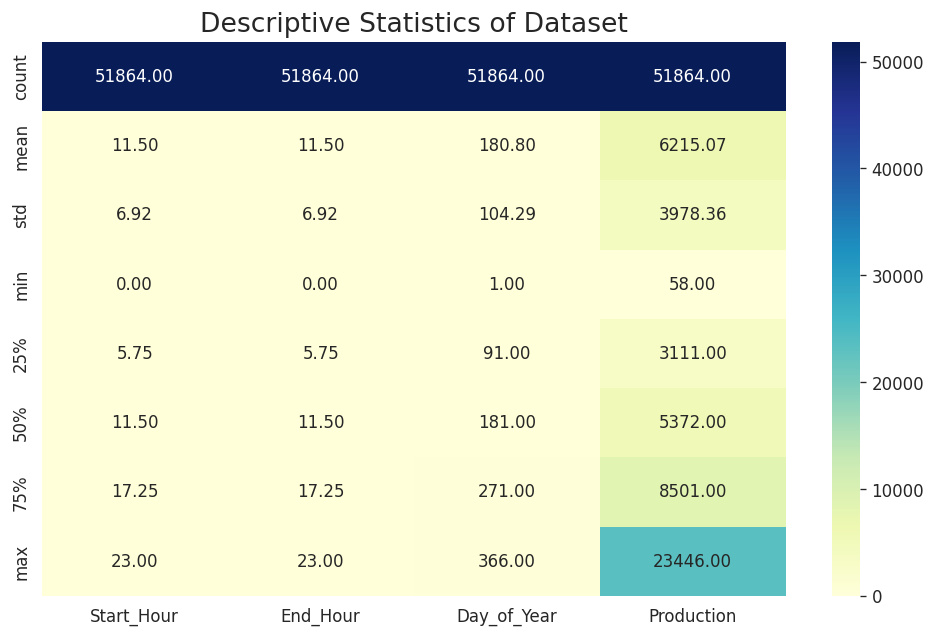

In [10]:
# Compute descriptive statistics
desc = df.describe()

# Plot heatmap of descriptive stats
plt.figure(figsize=(10,6))
sns.heatmap(desc, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Descriptive Statistics of Dataset", fontsize=16)
plt.show()

# Step 2: Feature Extraction

In [11]:
df1 = df.copy()

In [12]:
df1.head()

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production
0,11/30/2025,21,22,Wind,334,Sunday,November,Fall,5281
1,11/30/2025,18,19,Wind,334,Sunday,November,Fall,3824
2,11/30/2025,16,17,Wind,334,Sunday,November,Fall,3824
3,11/30/2025,23,0,Wind,334,Sunday,November,Fall,6120
4,11/30/2025,6,7,Wind,334,Sunday,November,Fall,4387


In [13]:
# Step 1: Convert 'Date' column to datetime
df1['Date'] = pd.to_datetime(df1['Date'], errors='coerce')

In [14]:
# Step 2: Extract Year, Month, Day
# Extract Year, Month, Day
df1['Year'] = df1['Date'].dt.year
df1['Month'] = df1['Date'].dt.month
df1['Day'] = df1['Date'].dt.day

# Time-related Features

In [15]:
df1['week'] = df1['Date'].dt.isocalendar().week

In [16]:
df1['Quarter']=df1['Date'].dt.quarter

In [17]:
df1['Weekday'] = df1['Date'].dt.weekday

In [18]:
df1['Hour'] = df1['Start_Hour'].astype(int)


In [19]:
df1['Is_Weekend'] = df1['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [20]:
df1['Month_Start'] = df1['Date'].dt.is_month_start.astype(int)

In [21]:
df1['Month_End'] = df1['Date'].dt.is_month_end.astype(int)

In [22]:
# Define meteorological seasons
def get_season(month):
    if month in [12, 1, 2]: return "Winter"
    elif month in [3, 4, 8]: return "Spring"
    elif month in [6, 7,8]: return "Summer"
    else: return 'Fall'

In [23]:
df1['Season'] = df1['Month'].apply(get_season)

In [24]:
df1.head()

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production,Year,Month,Day,week,Quarter,Weekday,Hour,Is_Weekend,Month_Start,Month_End
0,2025-11-30,21,22,Wind,334,Sunday,November,Fall,5281,2025,11,30,48,4,6,21,1,0,1
1,2025-11-30,18,19,Wind,334,Sunday,November,Fall,3824,2025,11,30,48,4,6,18,1,0,1
2,2025-11-30,16,17,Wind,334,Sunday,November,Fall,3824,2025,11,30,48,4,6,16,1,0,1
3,2025-11-30,23,0,Wind,334,Sunday,November,Fall,6120,2025,11,30,48,4,6,23,1,0,1
4,2025-11-30,6,7,Wind,334,Sunday,November,Fall,4387,2025,11,30,48,4,6,6,1,0,1


In [25]:
# Check missing values
print("\nMissing values:\n", df1.isnull().sum())


Missing values:
 Date           0
Start_Hour     0
End_Hour       0
Source         0
Day_of_Year    0
Day_Name       0
Month_Name     0
Season         0
Production     0
Year           0
Month          0
Day            0
week           0
Quarter        0
Weekday        0
Hour           0
Is_Weekend     0
Month_Start    0
Month_End      0
dtype: int64


In [26]:
df1.columns

Index(['Date', 'Start_Hour', 'End_Hour', 'Source', 'Day_of_Year', 'Day_Name',
       'Month_Name', 'Season', 'Production', 'Year', 'Month', 'Day', 'week',
       'Quarter', 'Weekday', 'Hour', 'Is_Weekend', 'Month_Start', 'Month_End'],
      dtype='object')

# Overall Production Distribution

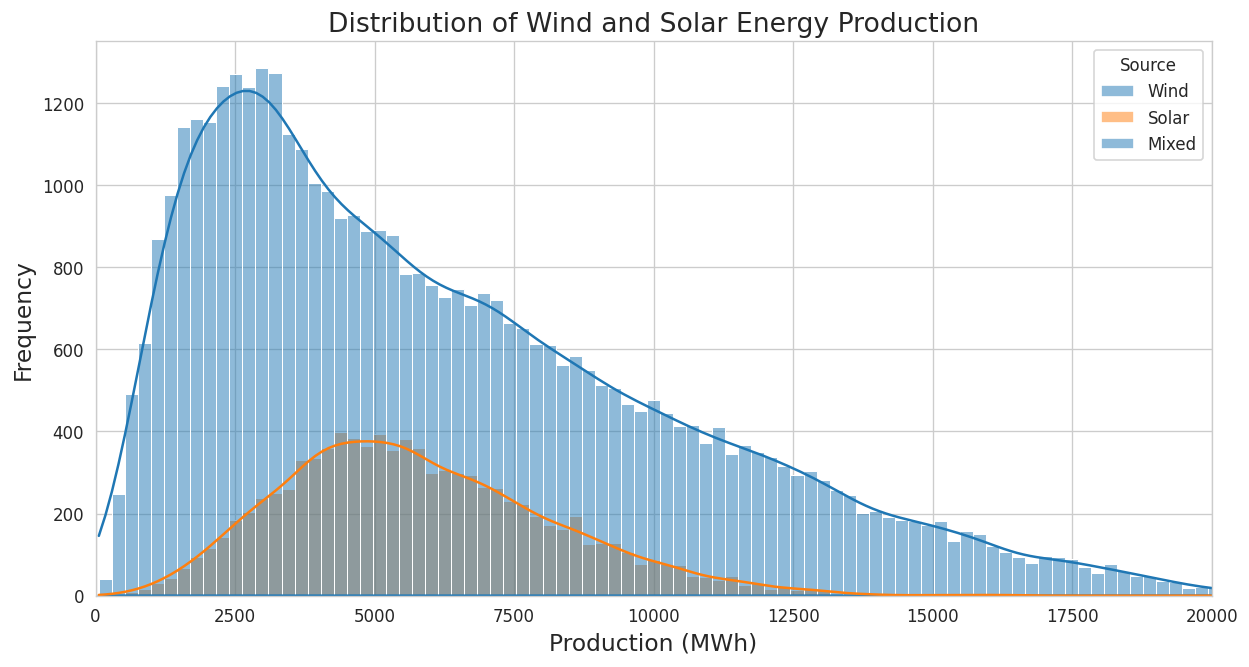

In [27]:
plt.figure(figsize=(12,6))
sns.histplot(df1, x='Production', hue='Source', bins=100, kde=True, palette=['#1f77b4','#ff7f0e'])
plt.title('Distribution of Wind and Solar Energy Production')
plt.xlabel('Production (MWh)')
plt.ylabel('Frequency')
plt.xlim(0,20000)
plt.show()


# Boxplot for Outliers

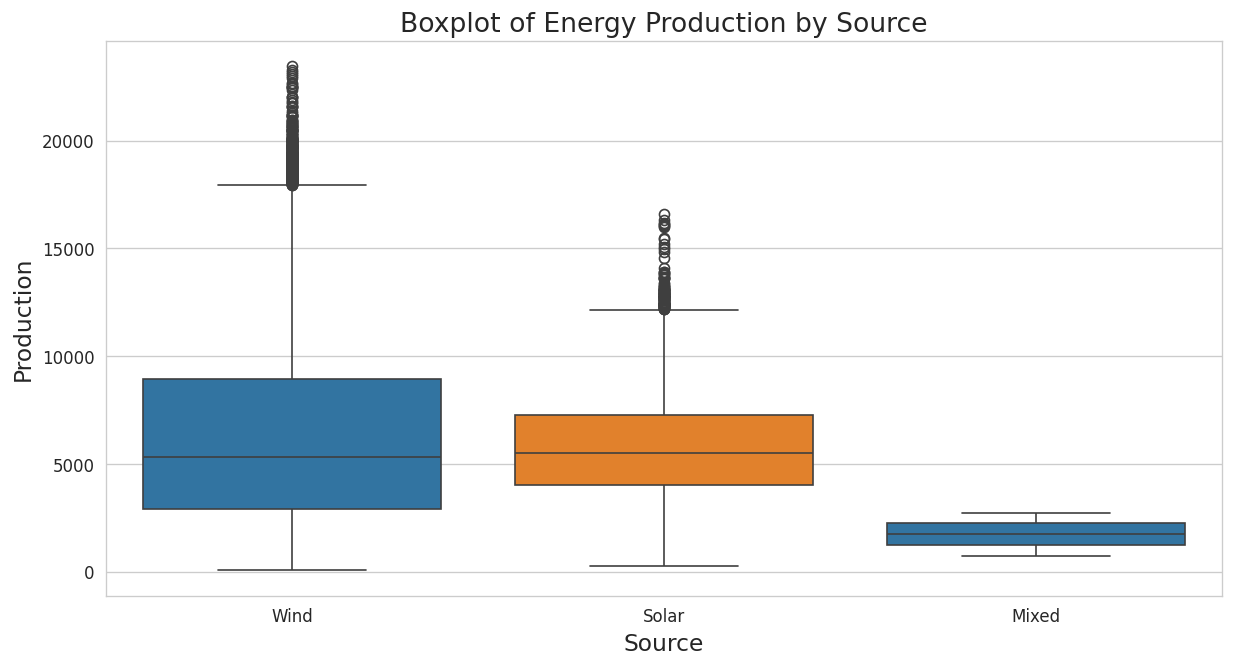

In [28]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Source', y='Production', data=df, palette=['#1f77b4','#ff7f0e'])
plt.title("Boxplot of Energy Production by Source")
plt.show()

# Step 4: Temporal Analysis

## 4.1 Daily Trend

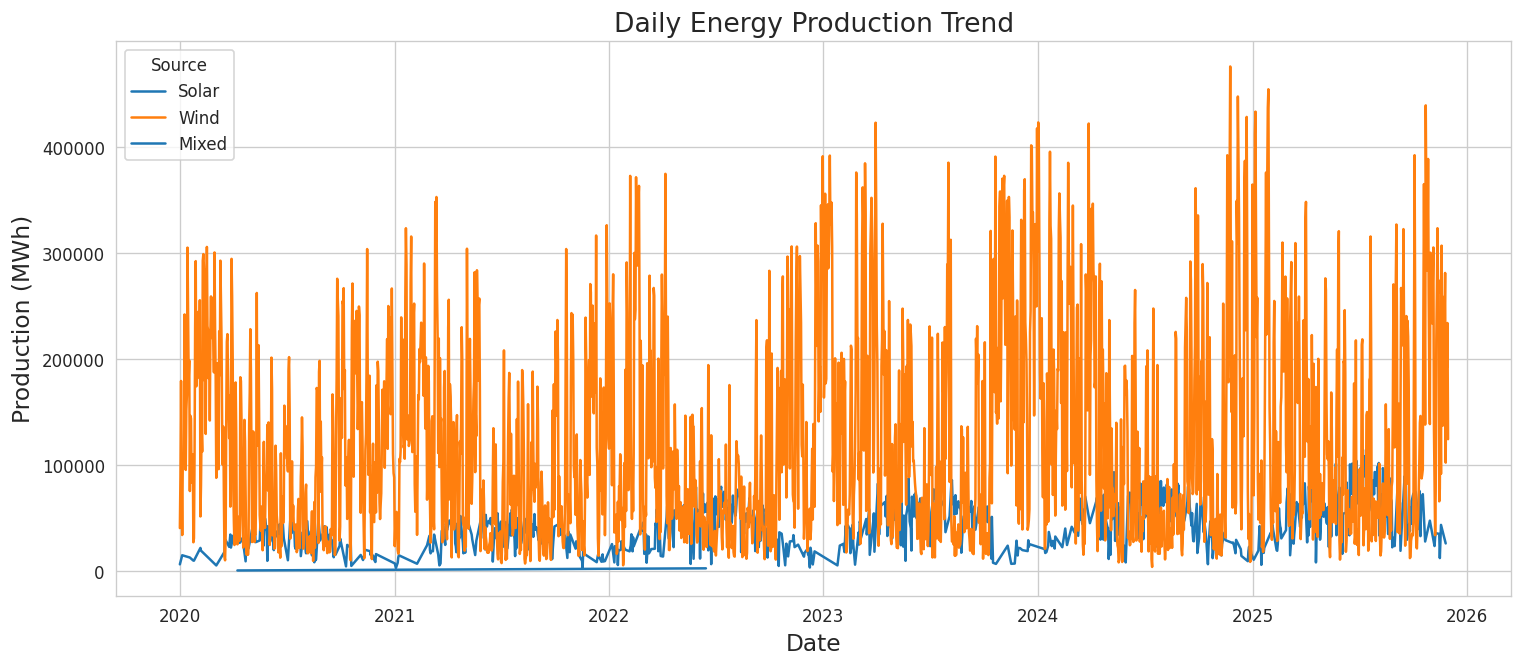

In [29]:
daily = df1.groupby(['Date','Source'])['Production'].sum().reset_index()
plt.figure(figsize=(15,6))
sns.lineplot(data=daily, x='Date', y='Production', hue='Source', palette=['#1f77b4','#ff7f0e'])
plt.title('Daily Energy Production Trend')
plt.xlabel('Date')
plt.ylabel('Production (MWh)')
plt.show()


### 4.2 Monthly Trend

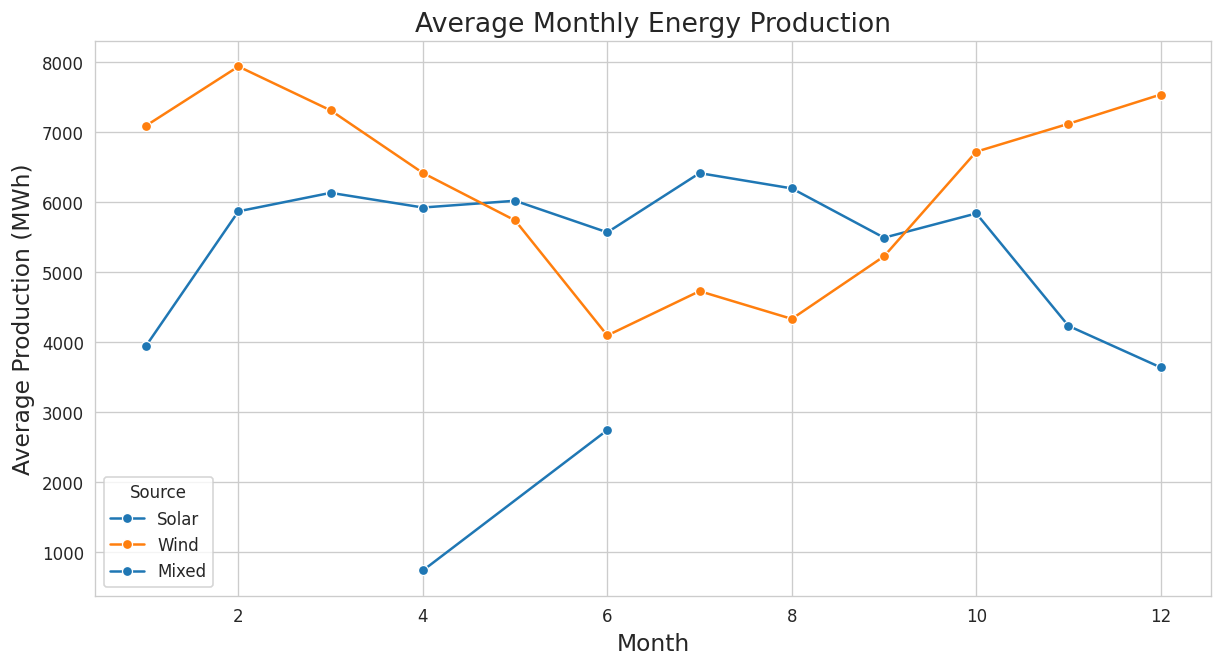

In [30]:
monthly = df1.groupby(['Month','Source'])['Production'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x='Month', y='Production', hue='Source', marker='o', palette=['#1f77b4','#ff7f0e'])
plt.title('Average Monthly Energy Production')
plt.xlabel('Month')
plt.ylabel('Average Production (MWh)')
plt.show()


### 4.3 Seasonal Trend

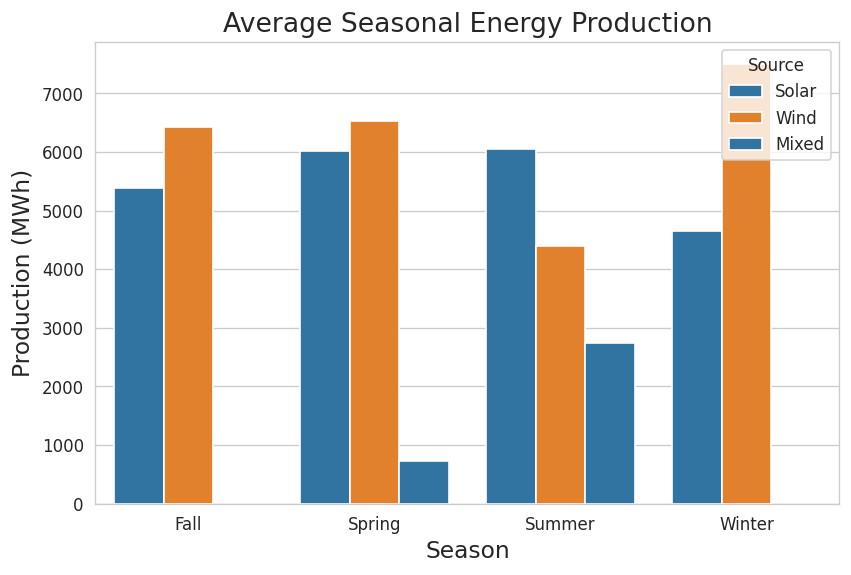

In [31]:
seasonal = df.groupby(['Season','Source'])['Production'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=seasonal, x='Season', y='Production', hue='Source', palette=['#1f77b4','#ff7f0e'])
plt.title('Average Seasonal Energy Production')
plt.ylabel('Production (MWh)')
plt.show()


# Step 5: Weekly and Hourly Patterns

### 5.1 Day of Week Trend

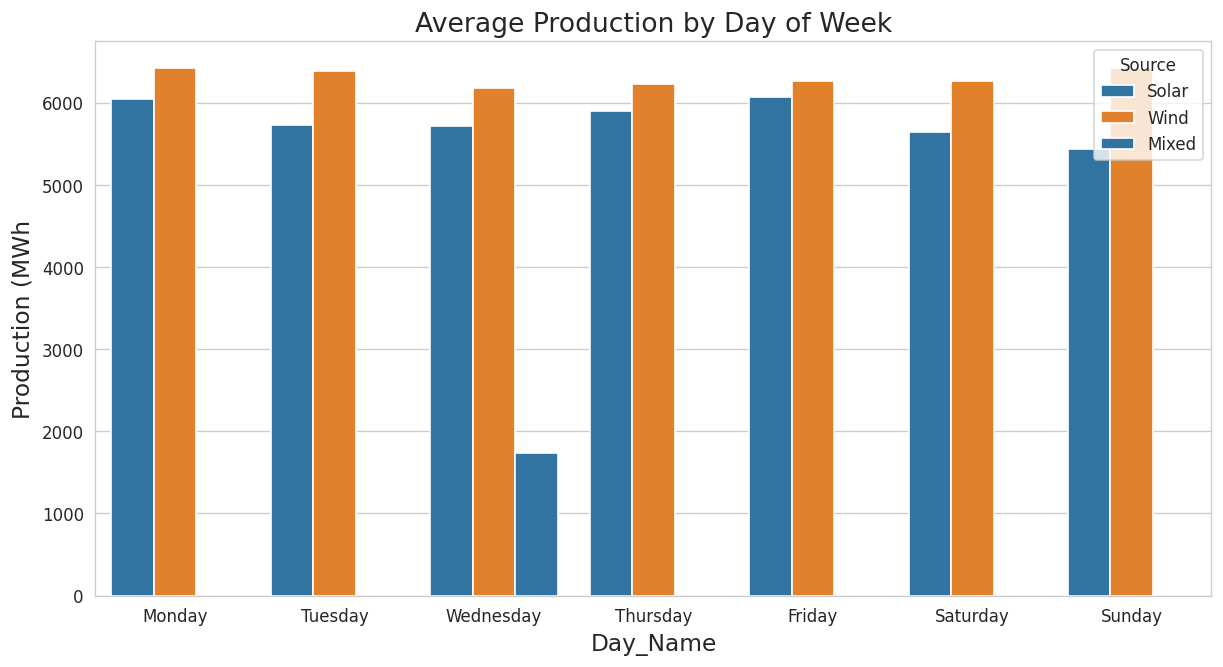

In [32]:
weekly = df1.groupby(['Day_Name','Source'])['Production'].mean().reset_index()
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekly['Day_Name'] = pd.Categorical(weekly['Day_Name'],categories=weekdays,ordered=True)
weekly = weekly.sort_values('Day_Name')

plt.figure(figsize=(12,6))
sns.barplot(data=weekly, x='Day_Name', y='Production', hue='Source', palette=['#1f77b4','#ff7f0e'])
plt.title('Average Production by Day of Week')
plt.ylabel('Production (MWh')
plt.show()

### 5.2 Hourly Trend (Diurnal Pattern)

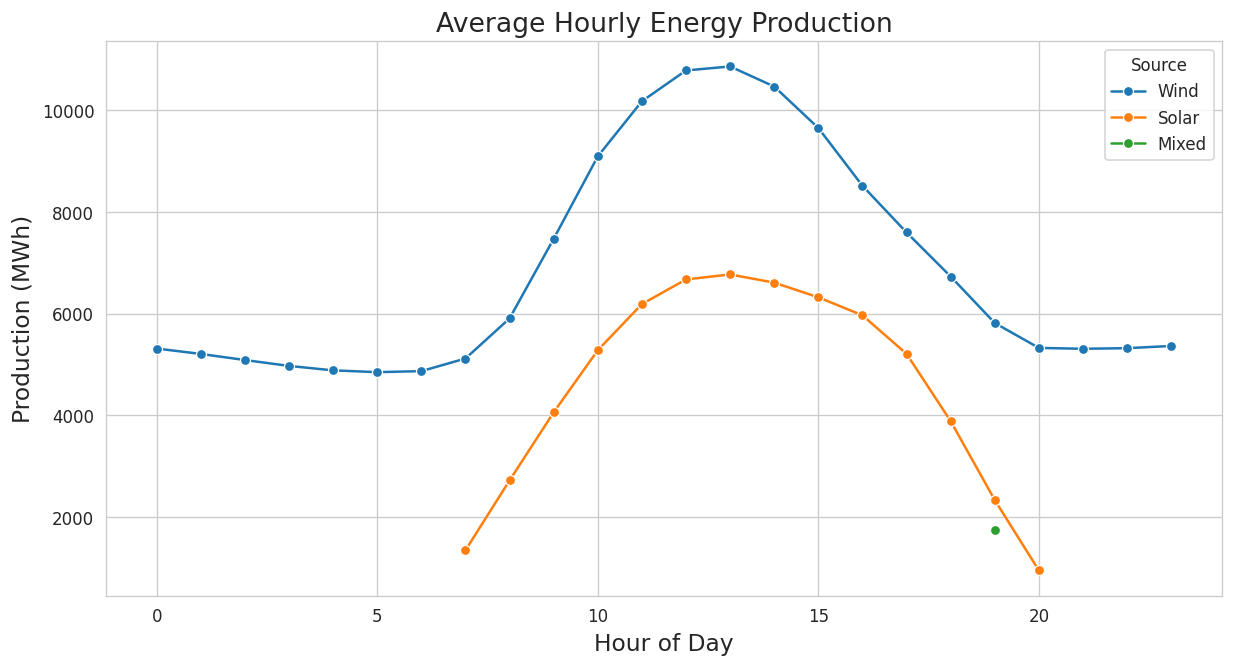

In [33]:
hourly = df1.groupby(['Hour','Source'])['Production'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=hourly, x='Hour', y='Production', hue='Source', marker='o')
plt.title('Average Hourly Energy Production')
plt.xlabel('Hour of Day')
plt.ylabel('Production (MWh)')
plt.show()


# Step 6: Weekend vs Weekday

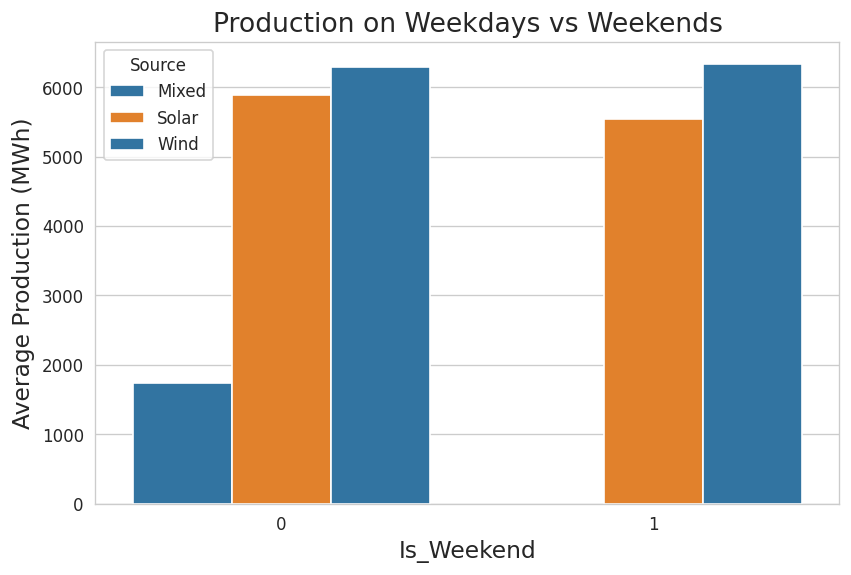

In [34]:
weekend = df1.groupby(['Is_Weekend','Source'])['Production'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=weekend, x='Is_Weekend', y='Production', hue='Source', palette=['#1f77b4','#ff7f0e'])
plt.title('Production on Weekdays vs Weekends')
plt.ylabel('Average Production (MWh)')
plt.show()


# Step 7: Quarterly Analysis

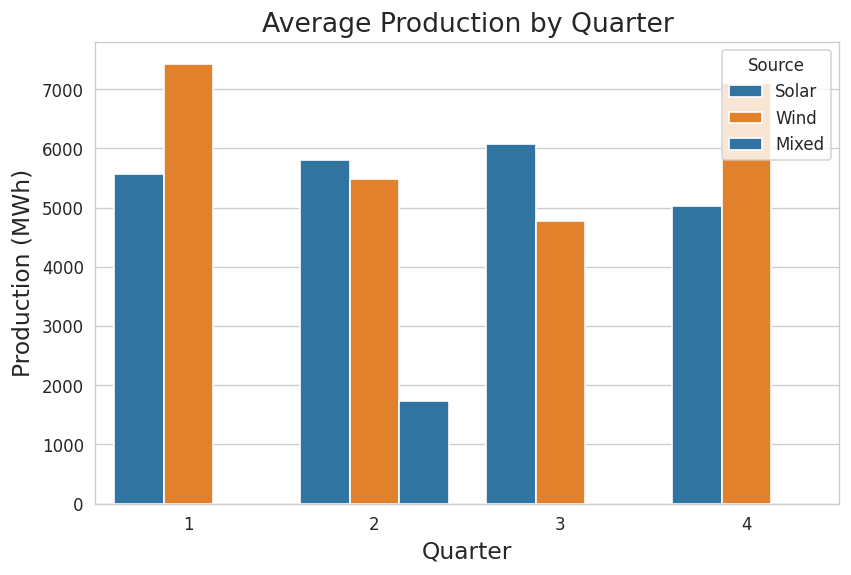

In [35]:
quarter = df1.groupby(['Quarter','Source'])['Production'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=quarter, x='Quarter', y='Production', hue='Source', palette=['#1f77b4','#ff7f0e'])
plt.title('Average Production by Quarter')
plt.ylabel('Production (MWh)')
plt.show()


# Step 8: Month Start vs Month End

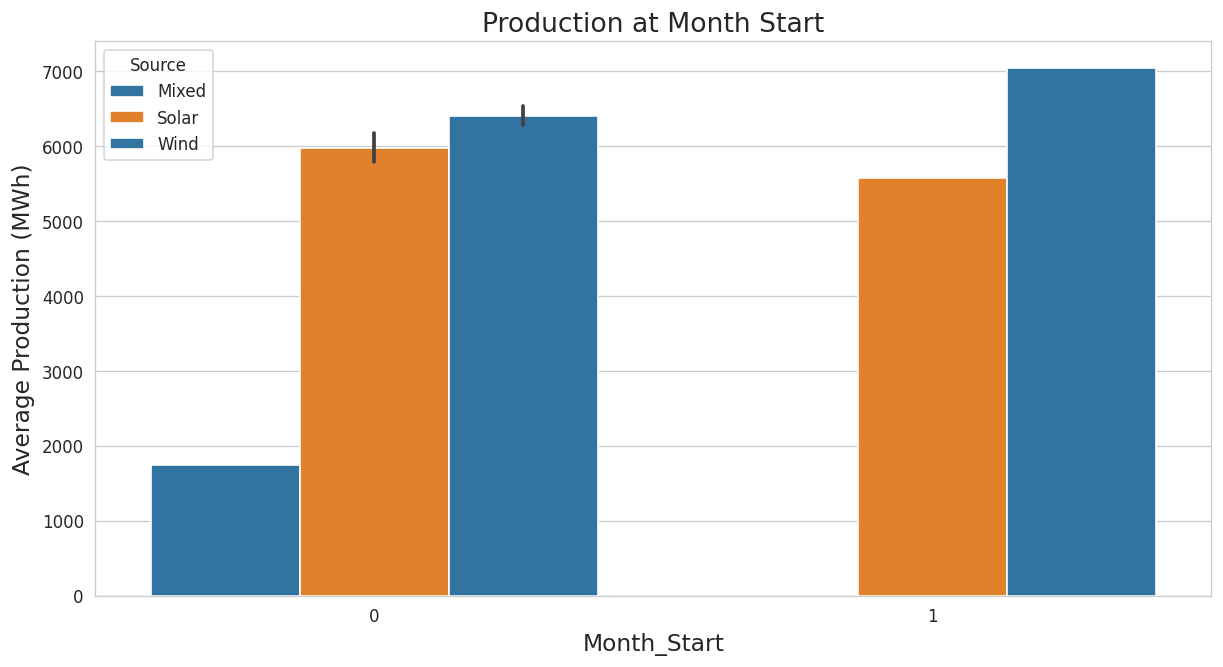

In [36]:
month_pos = df1.groupby(['Month_Start','Month_End','Source'])['Production'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(data=month_pos, x='Month_Start', y='Production', hue='Source', palette=['#1f77b4','#ff7f0e'])
plt.title('Production at Month Start')
plt.ylabel('Average Production (MWh)')
plt.show()


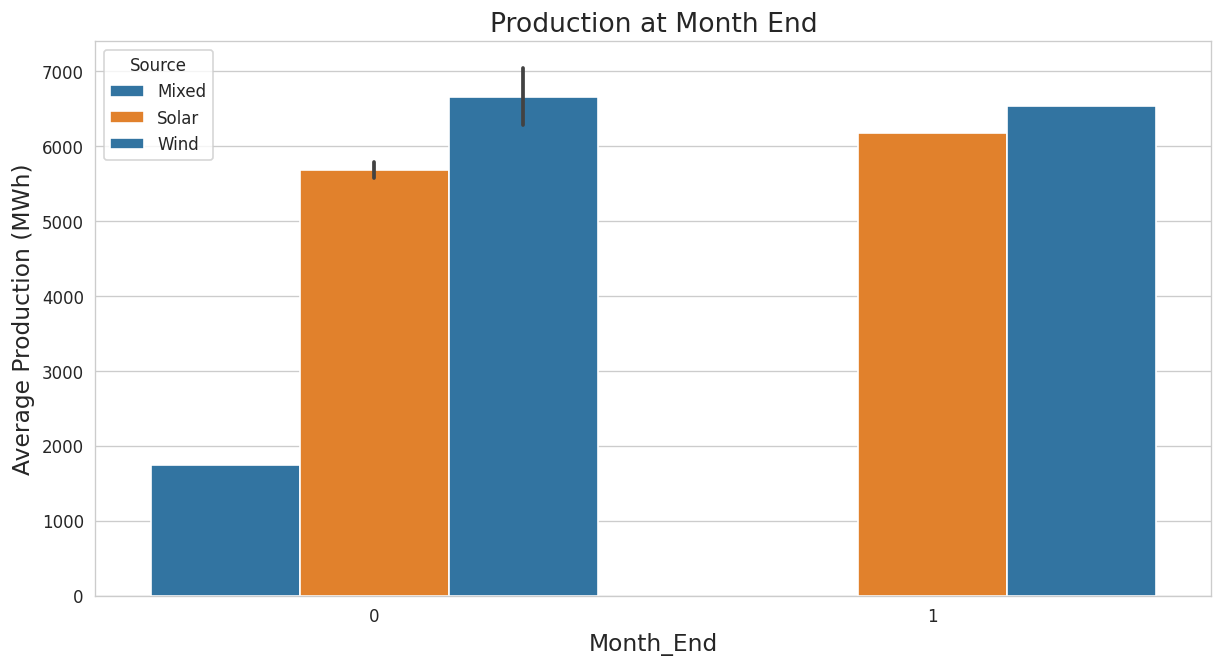

In [37]:
plt.figure(figsize=(12,6))
sns.barplot(data=month_pos, x='Month_End', y='Production', hue='Source', palette=['#1f77b4','#ff7f0e'])
plt.title('Production at Month End')
plt.ylabel('Average Production (MWh)')
plt.show()


## Step 9: Correlation Analysis

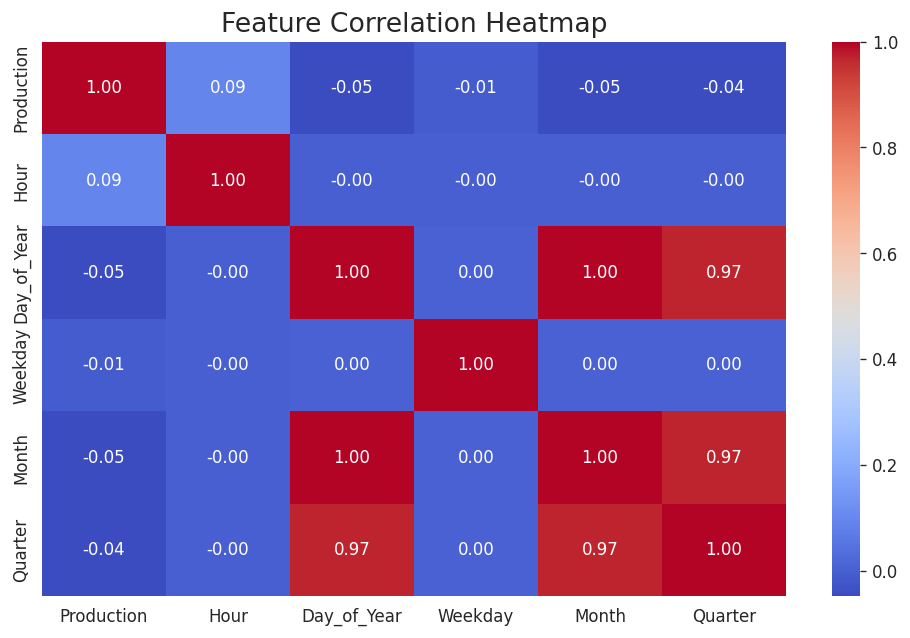

In [38]:
corr_features = ['Production','Hour','Day_of_Year','Weekday','Month','Quarter']
plt.figure(figsize=(10,6))
sns.heatmap(df1[corr_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


# Step 1: Prepare Time Series Data

In [39]:
# Step 1: Prepare Time Series Data
# Daily total production per Source
daily = df1.groupby(['Date','Source'])['Production'].sum().reset_index()

# Separate Wind and Solar
wind_daily = daily[daily['Source']=='Wind'].set_index('Date')['Production']
solar_daily = daily[daily['Source']=='Solar'].set_index('Date')['Production']

print("Wind daily shape:", wind_daily.shape)
print("Solar daily shape:", solar_daily.shape)


Wind daily shape: (2161,)
Solar daily shape: (1214,)


# Step 2: ARIMA / SARIMA Forecast (Daily Production)

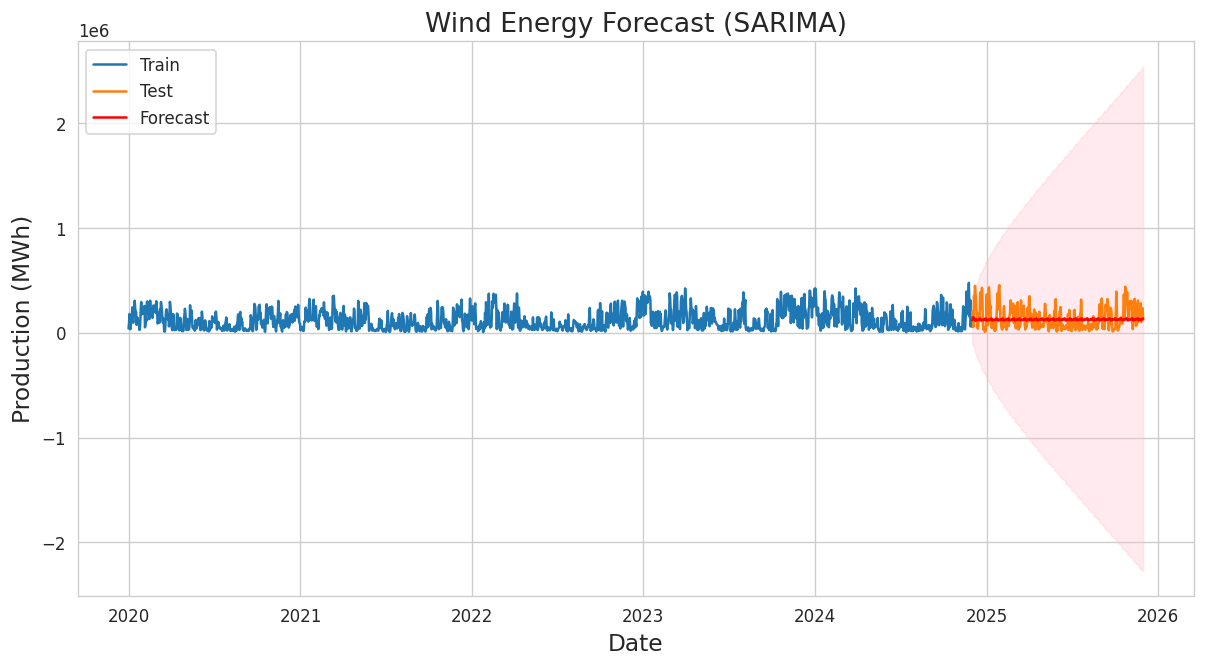

SARIMA RMSE: 107179.3856837829


In [40]:
# Train-test split (last 365 days as test)
train = wind_daily[:-365]
test = wind_daily[-365:]

# SARIMA model
model = SARIMAX(train, order=(5,1,0), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

# Forecast
forecast = model_fit.get_forecast(steps=365)
pred = forecast.predicted_mean
ci = forecast.conf_int()

# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, pred, label='Forecast', color='red')
plt.fill_between(test.index, ci['lower Production'], ci['upper Production'], color='pink', alpha=0.3)
plt.title('Wind Energy Forecast (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Production (MWh)')
plt.legend()
plt.show()

# Evaluation
rmse = np.sqrt(mean_squared_error(test, pred))
print("SARIMA RMSE:", rmse)


# Step 3: Prophet Forecast (Daily Production)

08:09:01 - cmdstanpy - INFO - Chain [1] start processing
08:09:02 - cmdstanpy - INFO - Chain [1] done processing


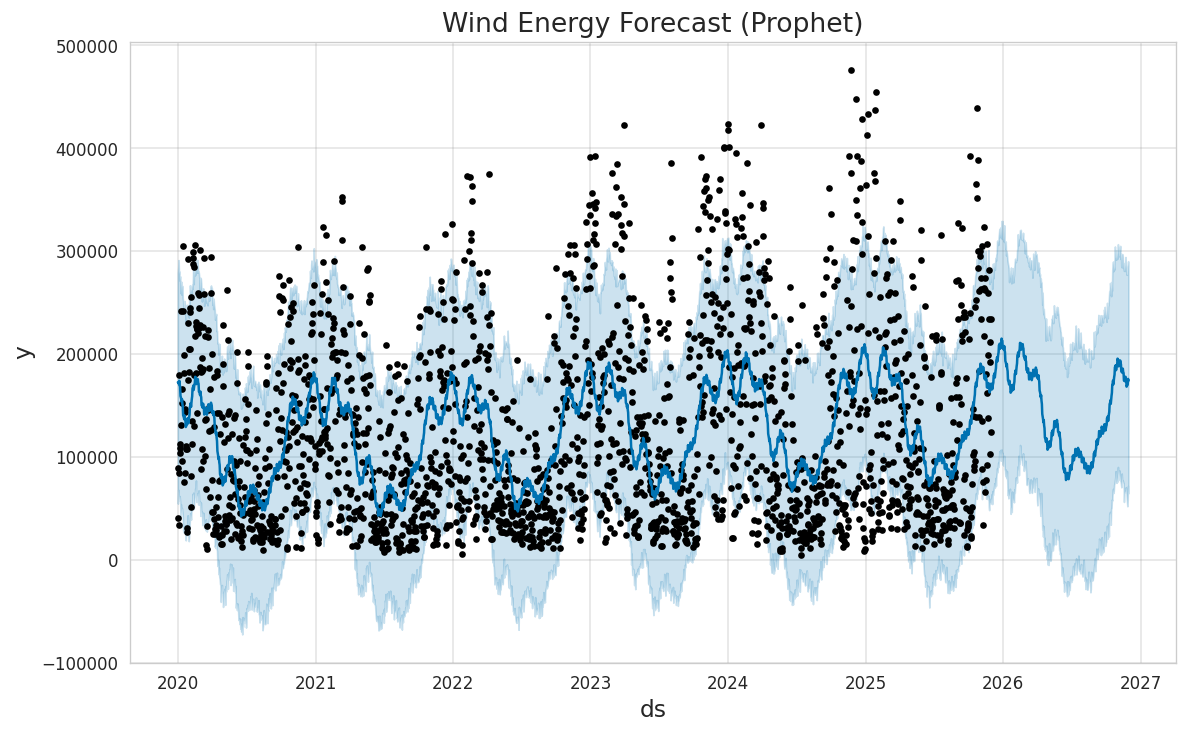

In [41]:
# Prepare Prophet data
wind_prophet = wind_daily.reset_index().rename(columns={'Date':'ds','Production':'y'})
solar_prophet = solar_daily.reset_index().rename(columns={'Date':'ds','Production':'y'})

# Prophet model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model.fit(wind_prophet)

# Future dataframe (365 days)
future = prophet_model.make_future_dataframe(periods=365)
forecast_prophet = prophet_model.predict(future)

# Plot
prophet_model.plot(forecast_prophet)
plt.title('Wind Energy Forecast (Prophet)')
plt.show()


# Step 4: Feature-Based Machine Learning (Hourly Production)

In [42]:
# Feature engineering
df_ml = df1.copy()
df_ml['Day_of_Year'] = df_ml['Date'].dt.dayofyear
df_ml['Source_enc'] = df_ml['Source'].map({'Wind':0,'Solar':1})

# Features & target
X = df_ml[['Year','Month','Day','Hour','Day_of_Year','Source_enc']]
y = df_ml['Production']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

# XGBoost
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost R2:", r2_score(y_test, y_pred_xgb))


Random Forest RMSE: 1315.7358184168995
Random Forest R2: 0.890788144335307
XGBoost RMSE: 2423.330043555768
XGBoost R2: 0.6295261383056641


# Step 5: Feature Importance (Random Forest)

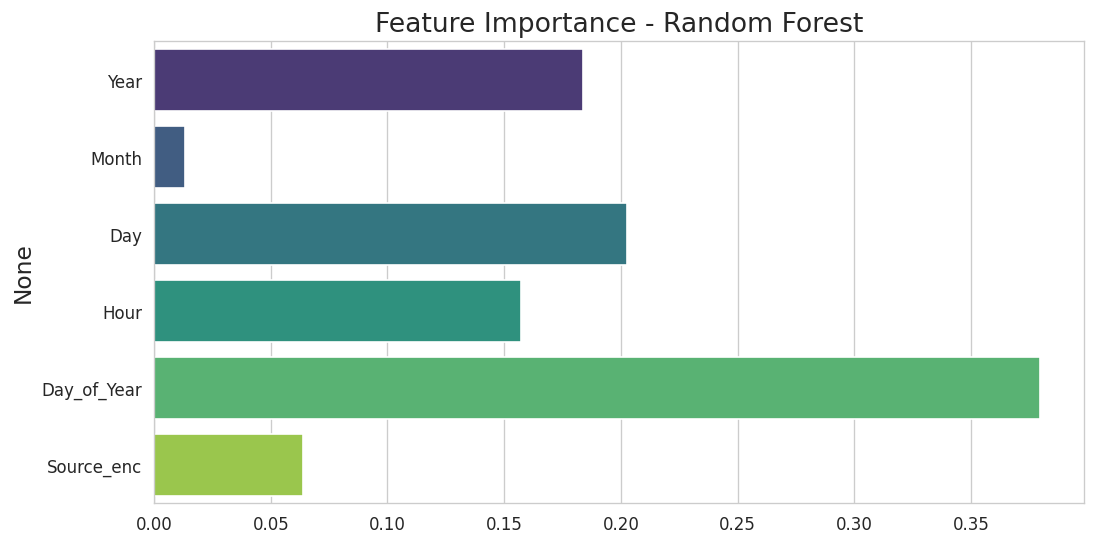

In [43]:
importances = rf.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10,5))
sns.barplot(x=importances, y=feat_names, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.show()


# Step 6: Save Predictions for Publication

In [44]:
# Combine actual vs predicted
results = X_test.copy()
results['Actual'] = y_test
results['RF_Predicted'] = y_pred_rf
results['XGB_Predicted'] = y_pred_xgb
results.to_csv('energy_production_predictions.csv', index=False)
print("Predictions saved for publication!")


Predictions saved for publication!
